# 导入模块

In [85]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from toad import quality
from toad.transform import Combiner
from toad.transform import WOETransformer
from toad.selection import select, stepwise
from toad.plot import bin_plot, badrate_plot
from toad.metrics import PSI, KS, AUC, KS_bucket
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
pd.set_option("display.width", 10000)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
%matplotlib inline

# 加载数据

In [7]:
train = pd.read_csv("../data/cs-training.csv").iloc[:, 1:]
testA = pd.read_csv("../data/cs-test.csv").iloc[:, 1:]

# 训练集与验证集

In [15]:
x_train, x_valid, y_train, y_valid = train_test_split(train.iloc[:, 1:], train["SeriousDlqin2yrs"], test_size=0.3, random_state=0)

train = x_train.join(y_train)
valid = x_valid.join(y_valid)

In [35]:
train.isnull().sum()

RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           20888
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       2736
SeriousDlqin2yrs                            0
dtype: int64

# 特征分箱

In [33]:
combiner = Combiner()
combiner.fit(train, y=train["SeriousDlqin2yrs"], method='dt', min_samples=0.05, exclude=['SeriousDlqin2yrs'])
train1 = combiner.transform(train)
bins = combiner.export()

# 分箱可视化

## 无担保贷款数量占总贷款数比率

[2.5599999389669392e-05, 0.011420521419495344, 0.02621154673397541, 0.0470005813986063, 0.06917506828904152, 0.09607098251581192, 0.13183673471212387, 0.21776090562343597, 0.2996138781309128, 0.41686537861824036, 0.5300196409225464, 0.7391083836555481, 0.9566141366958618]


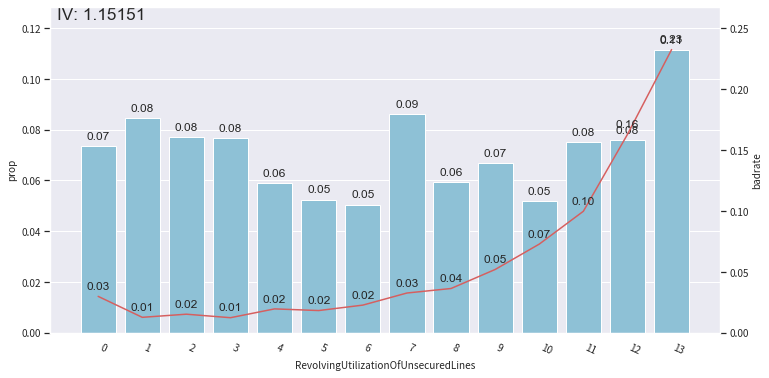

In [34]:
print(bins["RevolvingUtilizationOfUnsecuredLines"])
ax = bin_plot(train1, x="RevolvingUtilizationOfUnsecuredLines", target="SeriousDlqin2yrs")

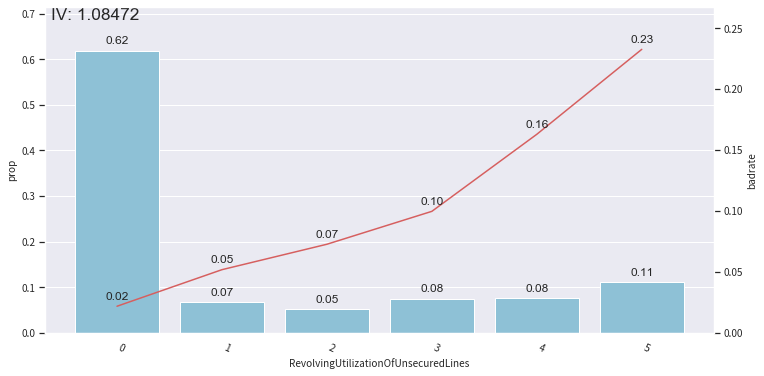

In [37]:
adj_bin = {"RevolvingUtilizationOfUnsecuredLines": [0.2996138781309128, 0.41686537861824036, 0.5300196409225464, 0.7391083836555481, 0.9566141366958618]}
combiner.set_rules(adj_bin)
train1 = combiner.transform(train)
ax = bin_plot(train1, x="RevolvingUtilizationOfUnsecuredLines", target="SeriousDlqin2yrs")

## 借款人年龄

[29.5, 35.5, 39.5, 43.5, 47.5, 49.5, 52.5, 55.5, 59.5, 62.5, 66.5, 74.5]


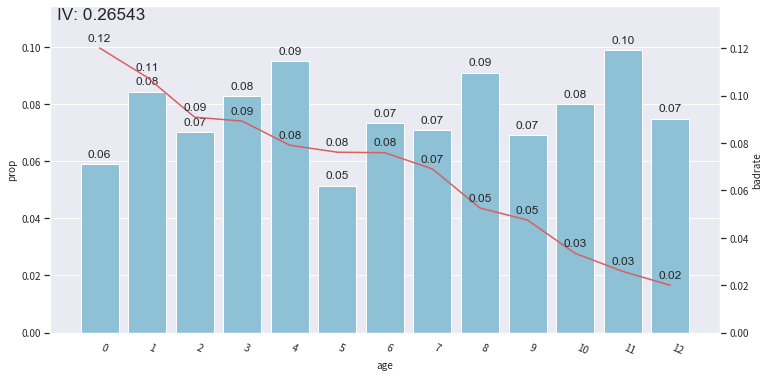

In [39]:
print(bins["age"])
ax = bin_plot(train1, x="age", target="SeriousDlqin2yrs")

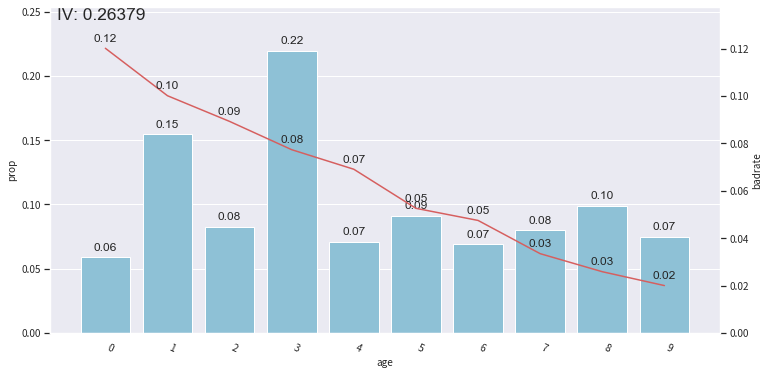

In [41]:
adj_bin = {"age": [29.5, 39.5, 43.5, 52.5, 55.5, 59.5, 62.5, 66.5, 74.5]}
combiner.set_rules(adj_bin)
train1 = combiner.transform(train)
ax = bin_plot(train1, x="age", target="SeriousDlqin2yrs")

## 近两年内逾期30-59天的次数

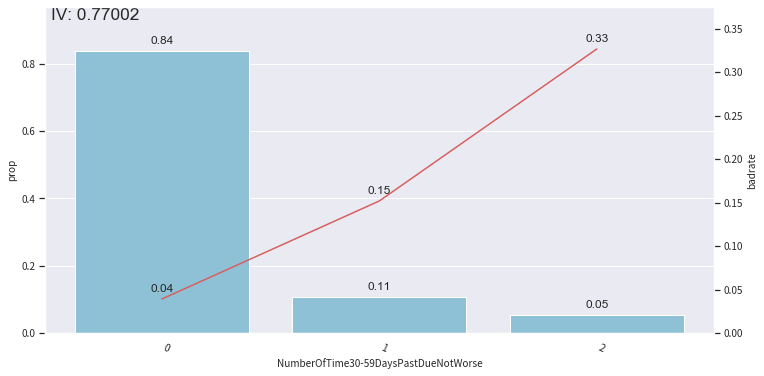

In [25]:
ax = bin_plot(train1, x="NumberOfTime30-59DaysPastDueNotWorse", target="SeriousDlqin2yrs")

## 负债率

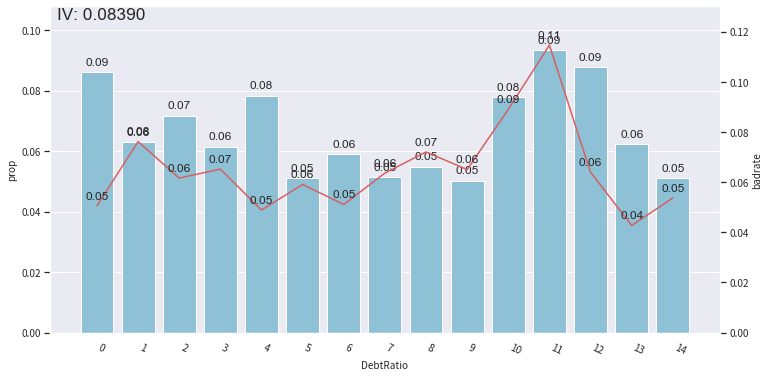

In [26]:
ax = bin_plot(train1, x="DebtRatio", target="SeriousDlqin2yrs")

## 月收入

[930.5, 2000.5, 2654.5, 3436.5, 4171.5, 4833.5, 5341.5, 5999.5, 6648.5, 7650.5, 8896.5, 10351.0, 12919.0]


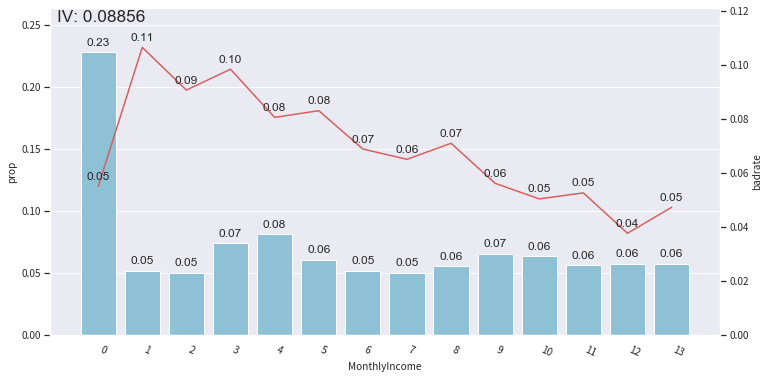

In [42]:
print(bins["MonthlyIncome"])
ax = bin_plot(train1, x="MonthlyIncome", target="SeriousDlqin2yrs")

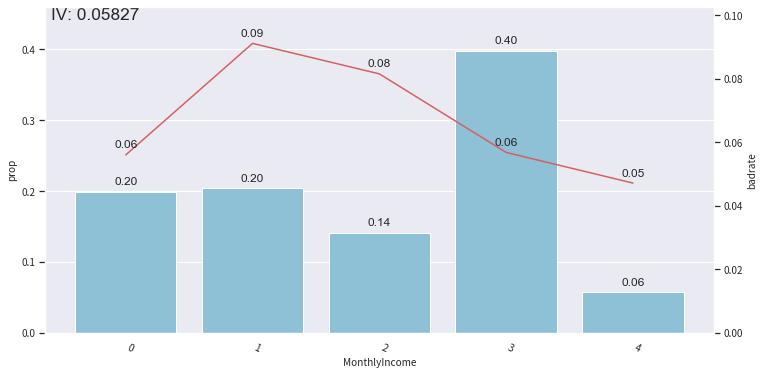

In [55]:
adj_bin = {"MonthlyIncome": [0, 3436.5, 4833.5, 12919.0]}
combiner.set_rules(adj_bin)
train1 = combiner.transform(train)
ax = bin_plot(train1, x="MonthlyIncome", target="SeriousDlqin2yrs")

## 车房贷的数量

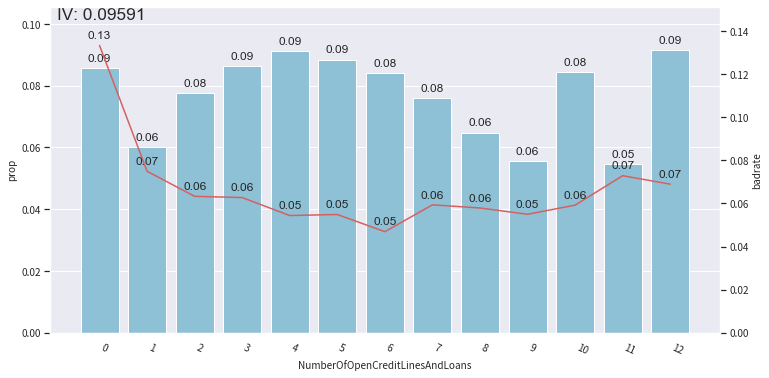

In [28]:
ax = bin_plot(train1, x="NumberOfOpenCreditLinesAndLoans", target="SeriousDlqin2yrs")

## 过往逾期90天及以上的次数

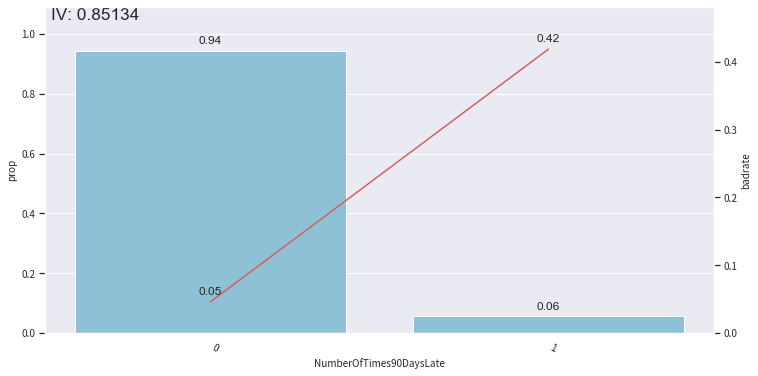

In [29]:
ax = bin_plot(train1, x="NumberOfTimes90DaysLate", target="SeriousDlqin2yrs")

## 不动产抵押贷款的数量

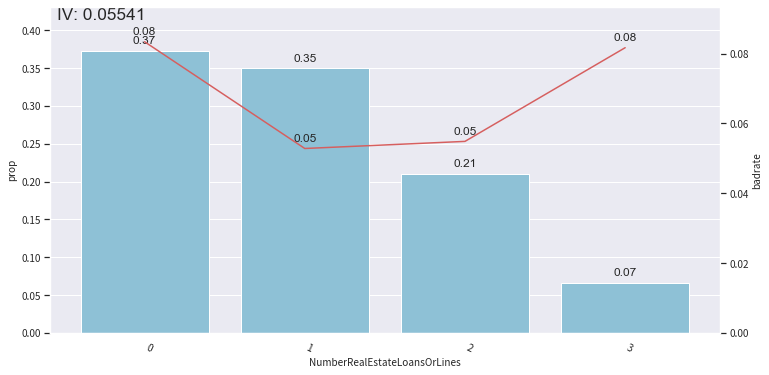

In [30]:
ax = bin_plot(train1, x="NumberRealEstateLoansOrLines", target="SeriousDlqin2yrs")

## 近两年内逾期60-89天的次数

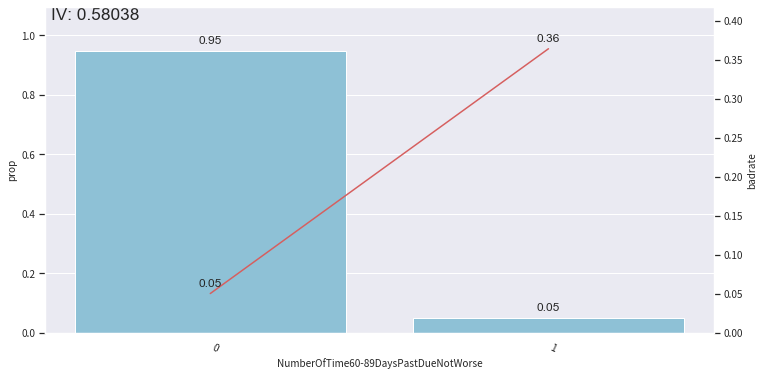

In [31]:
ax = bin_plot(train1, x="NumberOfTime60-89DaysPastDueNotWorse", target="SeriousDlqin2yrs")

## 家属数量

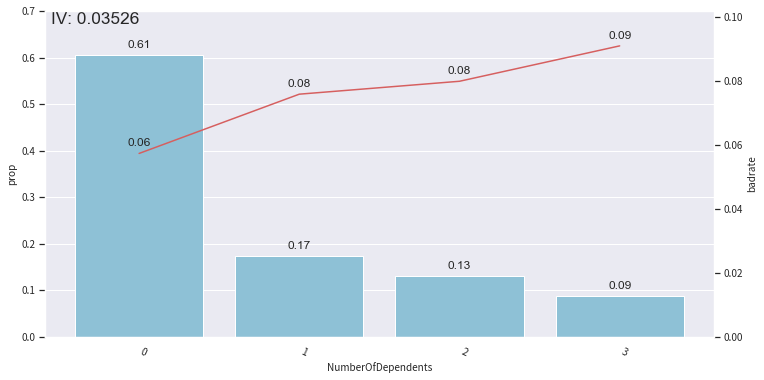

In [32]:
ax = bin_plot(train1, x="NumberOfDependents", target="SeriousDlqin2yrs")

In [56]:
train = combiner.transform(train)
valid = combiner.transform(valid)
testA = combiner.transform(testA)

# 删除特征

In [61]:
drop_colnames = ["DebtRatio", "NumberOfOpenCreditLinesAndLoans", "NumberRealEstateLoansOrLines"]
train.drop(drop_colnames, axis=1, inplace=True)
valid.drop(drop_colnames, axis=1, inplace=True)
testA.drop(drop_colnames, axis=1, inplace=True)

# WOE编码

In [65]:
woe = WOETransformer()
train_woe = woe.fit_transform(train, train["SeriousDlqin2yrs"], exclude=["SeriousDlqin2yrs"])
valid_woe = woe.transform(valid)
testA_woe = woe.transform(testA)

# 特征筛选

## 缺失率、IV值、相关系数

In [69]:
train_woe, drop_lst = select(train_woe, train_woe["SeriousDlqin2yrs"], empty=0.6, iv=0.001, corr=0.7, return_drop=True, exclude=["SeriousDlqin2yrs"])
valid_woe = valid_woe[train_woe.columns.tolist()]
testA_woe = testA_woe[train_woe.columns.tolist()]

## 逐步回归

In [72]:
train_woe = stepwise(train_woe, train_woe["SeriousDlqin2yrs"], 
                     exclude=["SeriousDlqin2yrs"], 
                     direction="both", 
                     criterion="aic", 
                     estimator="ols", 
                     intercept=False)
valid_woe = valid_woe[train_woe.columns.tolist()]
testA_woe = testA_woe[train_woe.columns.tolist()]

# 建模

## 训练模型

Train得分为：0.84600  
Valid得分为：0.83454  
Private得分为：0.84280  
Public得分为：0.83949  
模型稳定性PSI：0.00140

In [93]:
base = LogisticRegression(random_state=0)
base.fit(train_woe.iloc[:, :-1], train_woe["SeriousDlqin2yrs"])

base_train = base.predict_proba(train_woe.iloc[:, :-1])[:, 1]
print("训练集AUC：", AUC(base_train.tolist(), train_woe["SeriousDlqin2yrs"].values.tolist()))
base_valid = base.predict_proba(valid_woe.iloc[:, :-1])[:, 1]
print("验证集AUC：", AUC(base_valid.tolist(), valid_woe["SeriousDlqin2yrs"].values.tolist()))

testA_woe["Probability"] = base.predict_proba(testA_woe[["RevolvingUtilizationOfUnsecuredLines", "NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse"]])[:, 1]
testA_woe["id"] = range(1, len(testA_woe)+1)
testA_woe[["id", "Probability"]].to_csv("../data/baseline_result.csv", index=False)

print("模型稳定性PSI：", PSI(base_train, testA_woe["Probability"]))

验证集AUC： 0.8345365783952304


## 贝叶斯优化